### Задача:
Есть таблица с результатами A/B-теста. В числовой колонке показаны значения выручки по каждому пользователю за период эксперимента.

Нужно понять, стали ли мы больше зарабатывать с пользователя или нет. Вы уже знаете о существовании t-теста, U-теста Mann-Whitney и бутстрапа. Открытый вопрос: какой инструмент использовать?

1. Посчитайте p-value тремя способами: t-тест, U-тест, бутстрап средних

2. Сравните результат между тестом и контролем по всем этим кейсам

3. Напишите выводы, которые можно сделать на основе анализа примененных критериев. Напишите, почему мы должны использовать тот или иной инструмент: каких предположений о случайной величине нужно придерживаться, какие условия необходимы и т.п.

In [26]:
import numpy as np
import pandas as pd
import scipy.stats as sts
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pingouin as pg

plt.style.use('ggplot')

In [27]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [28]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

___

In [29]:
# Загружаем данные и смотрим на них
df = pd.read_csv('hw_bootstrap.csv', sep=';')
df.head(5)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [30]:
# Уберем ненужную нам колонку с порядковыми номерами
df.drop(columns=df.columns[0], inplace=True)

In [31]:
# Проверим данные на пустые значения
df.isna().sum()

value                0
experimentVariant    0
dtype: int64

In [32]:
# Посмотрим типы данных
df.dtypes

value                object
experimentVariant    object
dtype: object

In [33]:
# Приводим даннык в колонке value к типу float
df.value = df.value.apply(lambda x: x.replace(',','.')).astype(float)

In [34]:
# Делаем две выборки по данным из двух групп
sample_1 = df[df.experimentVariant == 'Control'].value
sample_2 = df[df.experimentVariant == 'Treatment'].value

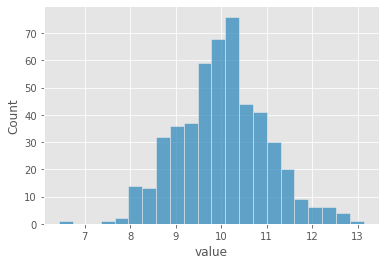

In [35]:
# Построим график распределения первой выборки
sns.histplot(sample_1);

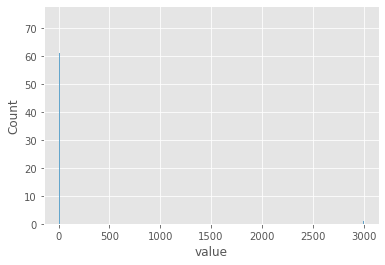

In [36]:
# Построим график распределения второй выборки
sns.histplot(sample_2);

Визуально видно, что второе распределение не является нормальным, но давайте это еще проверим

In [37]:
# Проведем тест на нормальность распределения
pg.normality(df, dv='value', group='experimentVariant', method = 'normaltest')

,W,pval,normal
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


In [38]:
# Проверим гомогенность дисперсий
pg.homoscedasticity(data = df, dv='value', group='experimentVariant')

,W,pval,equal_var
levene,4.297837,0.038417,False


___

#### Предобработку выполнили, приступим к решению.

##### Выведем гипотезы:

**Для бутстрапа и T-критерия:**

H0: Средние значения в двух группах не различаются
H1: Средние значения различаются

**Для Манн-Уитни:**

H0: Случайно выбранное значение из одной выборки равновероятно больше или меньше случайного значения из другой выборки
H1: Случайно выбранное значение из одной выборки не равновероятно больше или меньше случайного значения из другой выборки



  0%|          | 0/1000 [00:00<?, ?it/s]

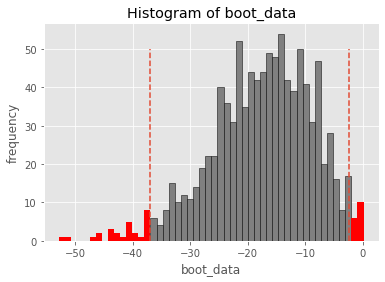

In [39]:
# Применяем бутстрап
booted_data = get_bootstrap(sample_1, sample_2)

In [40]:
# p-value
booted_data['p_value']

0.045992891347957456

In [41]:
# Доверительные интервалы
booted_data["quants"]

,0
0.025,-37.019056
0.975,-2.391678


**Результат бутстрап средних значений:**

**Средние значения в группах test и control различаются на заданном уровне значимости**, тк  нулевое значение разницы между двумя средними не попадает в доверительный интервал

**p-value < 0.05 позволяет отвергнуть нулевую гипотезу в пользу альтернативной**.

In [42]:
# Используем метод Манна-Уитни
sts.mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

**Результат U критерия Манна-Уитни:**

**Значение p-value > 0.05** нет оснований отвергнуть нулевую гипотезу,  статистически значимые различия между группами test и control отстутствуют

In [43]:
# Используем t test
stats.ttest_ind(sample_1, sample_2)

Ttest_indResult(statistic=-2.0729020485356604, pvalue=0.038437593613498765)

**Результат T-test:**

**Значение p-value < 0.05** есть основания отклонить нулевую гипотезу, т.к присутсвуют статистически значимые различия между группами test и control 

___

Вывод:

Тесты показали разные результаты, но при проведении предобработке данных мы выявили, что данные не удовлетваряют условий для применения некоторых из тестов:
- Отсутсвует нормальность распределения и гомогенность дисперсии, что влияет на результат t-test'a, а значет его в данном случае лучше не применять
- У нас достаточно большое кол-во данных, потому применять бутстрап в данном случае нелогично.

**Потому в данной ситуации лучшим решением будет воспользовать методом Манна-Уитни.
По результатом теста статестически значимых различий не было, а значит заработать нам не удалось.**


Давайте попробуем избавиться от выбросов и посмотреть на результаты еще раз.

___

In [44]:
# найдем значения сильно превышающие среднее
sample_2[sample_2.values > 100]

995    1000.0
996    1200.0
997    1500.0
998    2000.0
999    3000.0
Name: value, dtype: float64

In [45]:
# Заменим выбросы медианным значением
f_sample_2 = sample_2
f_sample_2[f_sample_2.values > 100] = sample_2.quantile(0.5)

/var/folders/6z/mmgx3mxs29n469zt9_ldj7840000gn/T/ipykernel_80749/3811824033.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_sample_2[f_sample_2.values > 100] = sample_2.quantile(0.5)


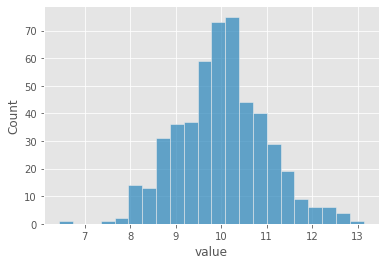

In [46]:
# Посмотрим на распределение
sns.histplot(f_sample_2);

Теперь можно нормально использовать t-test

In [47]:
# Используем t test
stats.ttest_ind(sample_1, f_sample_2).pvalue

0.9340741515233673

**Результат T-test:**

**Значение p-value > 0.05** оснований отклонить нулевую гипотезу нет, статистически значимые различия между группами test и control отсутсвуют

In [48]:
# Используем метод Манна-Уитни
sts.mannwhitneyu(sample_1, f_sample_2).pvalue

0.9242852188382452

**Результат U критерия Манна-Уитни:**

**Значение p-value > 0.05** нет оснований отвергнуть нулевую гипотезу,  статистически значимые различия между группами test и control отстутствуют

  0%|          | 0/1000 [00:00<?, ?it/s]

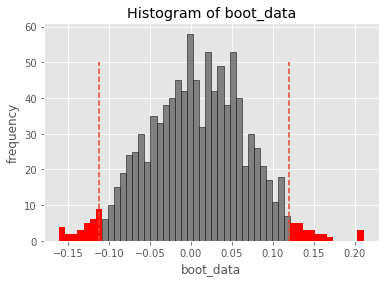

0.9062321053005118

In [49]:
# Применяем бутстрап
f_booted_data = get_bootstrap(sample_1, f_sample_2)
f_booted_data['p_value']

In [50]:
f_booted_data["quants"]

,0
0.025,-0.112448
0.975,0.119663


**Результат бутстрап средних значений:**

**Значение p-value > 0.05** оснований отклонить нулевую гипотезу нет, статистически значимые различия между группами test и control отсутсвуют.
Нульевое значение разницы попадает в доверительный интервал.

___

Вывод:

Как видно теперь все 3 теста показывают примерно одинаковый p-value.
Все три теста оставляют нулевую гипотезу, а значит денег мы не заработали.

Так как распределение нормальноe, с данными в текущем формате лучше было использовать t-test.